In [1]:
%%configure -f
{"conf": {"spark.pyspark.python":"/home/hadoop/path/to/venv/bin/python3"}}

# <font color='blue'>Churn Prediction Data Modeling</font>

<div class="alert alert-block alert-info">

This notebook is dedicated to the following tasks:
    <li>load and clean data</li>
    <li>pre-process data and create new features</li>
    <li>stratified split features dataset into train and test sets</li>
    <li>spot check 6 classifiers with default parameters on the train set</li>
    <li>tune hyperparameters for the best classifier</li>
    <li>evaluate metrics and display all the results</li>
</div>

## <font color='blue'>Build the Workspace</font>

In [2]:
# import PySpark libraries and packages

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, 
    first, last, 
    desc, asc,
    avg, count, countDistinct, 
    when, isnull, isnan,
    from_unixtime, 
    datediff,
    )

# libraries and packages for modeling

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.feature import (
    OneHotEncoder, 
    OneHotEncoderModel
)

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC,
    NaiveBayes
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1644234991316_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("Sparkify")
        .getOrCreate())

#spark.sparkContext.setLogLevel("ERROR")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# check the available memory in the cluster, uncomment on AWS
print('Available AWS-EMR Memory: {}'.format(spark.sparkContext
                                    .getConf().get('spark.driver.memory')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Available AWS-EMR Memory: 2048M

In [5]:
# import python libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn metrics related packages

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score

# import library for enhanced plotting

import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette('PuBuGn_r')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Load, Preprocess, Process and Split Dataset Functions</font>

In [6]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw dat
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded...")
    
    return df


def save_data(df, data_path):
    """
    Saves the PySpark dataframe to a file.
    
    INPUT:
            df (PySpark dataframe) - data to be saved
            data_path (str) - path for datafile
    OUTPUT:
            none
    
    """
    
    df.write.json(data_path)
    
    
def clean_data(df):
    """
    Performs basic cleaning operations on the raw data:
        - removes entries with missing userId
        - rescale timestamp columns to seconds
        - drop unnecesary columns
            - personal information columns
            - song information columns
            - web and browser information
            - timestamp columns in miliseconds

    INPUT:
        (PySpark dataframe) - dataframe of raw data
    OUTPUT:
        (PySpark dataframe) - dataframe of cleaned data
    """

    # print message to indicate the start of the process
    print("Cleaning the data ...")

    # print a count of rows before cleaning
    initial_records = df.count()
    print("Dataset has {} rows initially.".format(initial_records))

    # filter out all the records without userId
    df = df.where(df.userId != "")

    # rescale the timestamp to seconds (initially in miliseconds)
    df = df.withColumn("log_ts", df.ts/1000.0)
    df = df.withColumn("reg_ts", df.registration/1000.0)

    # drop several unnecessary columns
    cols_to_drop = ("firstName", "lastName", "location",
                    "artist", "song", "length",
                    "userAgent", "method", "status",
                    "ts", "registration"
                   )
    df = df.drop(*cols_to_drop)


    # print end of process message
    print("Finished cleaning the data ...")

    # print a count of rows after cleaning
    removed_rows = initial_records - df.count()

    print("Cleaned dataset has {} rows, {} rows were removed". \
        format(df.count(), initial_records - df.count()))

    return df

def preprocess_data(df):

    """
    Prepare the data for modeling via creating several features.

        - reg_date (date) - month-year of the registration

        - create windows grouped on userId and sessionId

         - firstevent_ts (timestamp) - first time an user is active
         - lastevent_ts (timestamp) - last time an user is active

         - init_days_interv (float) - days between registration and first activity
         - tenure_days_interv (float) - days between registration and last activity
         - active_days (float) - days the user has some activity on the platform
         - session_h (float) - session's duration in hours

     INPUT:
         df (PySpark dataframe) - cleaned dataframe
     OUTPUT:
         df (PySpark dataframe) - dataframe with the listed features added
    """

    # extract registration month and year from timestamp
    df = df.withColumn("reg_date", from_unixtime(col("reg_ts"), "MM-yyyy"))

    # create window: data grouped by userId, time ordered
    win_user = (W.partitionBy("userId")
            .orderBy("log_ts")
            .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))

    # create window: data grouped by sessionId and userId, time ordered
    win_user_session = (W.partitionBy("sessionId", "userId")
                        .orderBy("log_ts")
                        .rangeBetween(W.unboundedPreceding, W.unboundedFollowing))

    # record the first time an user is active
    df = df.withColumn("firstevent_ts", first(col("log_ts")).over(win_user))
    # record the last time an user is active
    df = df.withColumn("lastevent_ts", last(col("log_ts")).over(win_user))

    # warmup time = registration time to first event in days
    df = df.withColumn("init_days_interv",
                       (col("firstevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))

    # tenure time = registration time to last event in days
    df = df.withColumn("tenure_days_interv",
                       (col("lastevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))

    # active time =  days between the first event and the last event in days
    df = df.withColumn("active_days",
                       (col("lastevent_ts").cast("long")-col("firstevent_ts").cast("long"))/(24*3600))

    # create column that records the individual session's duration in hours
    df = df.withColumn("session_h",
                    (last(df.log_ts).over(win_user_session) \
                     - first(df.log_ts).over(win_user_session))/3600)

    # drop columns
    df = df.drop("reg_ts", "log_ts")

    return df


def build_features(df):

    """
    Features engineered to be used in modelling.

        - nr_songs (int) - total number of songs user listened to
        - nr_playlist (int) - number of songs added to the playlist

        - nr_friends (int) - number of friends added through "Add Friend"

        - nr_likes (int) - total number of "Thumbs Up" of the user
        - nr_dislikes (int) - total number of "Thumbs Down" of the user

        - nr_downgrades (int) - total number of visits to "Downgrade" page by the user
        - nr_upgrades (int) - total number of visits to "Upgrade" page by the user

        - nr_home (int) - total number of visits to "Home" page by the user
        - nr_settings (int) - total number of visits to "Settings" page by the user

        - nr_error (int) - total number of errors encountered by the user

        - nr_ads (int) - total number of ads the user got
        - nr_sessions (int) - number of sessions of the user
        - n_acts (int) - total number of actions taken by the user

        - avg_sess_h (float) - average session length in hours
        - acts_per_session (float) - average number of actions per session for the user
        - songs_per_session (float) - average numer of songs listened per session by the user
        - ads_per_session (float) - average number of ads per session, received by user

        - init_days_interv (int) - time interval in days from registration to the first action of the user
        - tenure_days_interv (int) - time interval in days from registration to the last action of the user
        - active_days (int) - number of days the user was active on the platform

        - gender (binary) - 1 for F (female), 0 for M (male)
        - level (binary) - 1 for paid, 0 for free

        - churn (binary) - 1 for "Cancellation Confirmation" page visit, 0 otherwise

    INPUT:
        df (PySpark dataframe) - preprocessed dataframe
    OUTPUT:
        df_feats (PySpark dataframe) - dataframe that contains engineered features
    """

    df_feats = df.groupBy("userId") \
        .agg(

            # count user's individual actions using all page visits

            count(when(col("page") == "NextSong", True)).alias("nr_songs"),
            count(when(col("page") == "Add to Playlist", True)).alias("nr_playlist"),

            count(when(col("page") == "Add Friend", True)).alias("nr_friends"),

            count(when(col("page") == "Thumbs Up", True)).alias("nr_likes"),
            count(when(col("page") == "Thumbs Down", True)).alias("nr_dislikes"),

            count(when(col("page") == "Downgrade", True)).alias("nr_downgrades"),
            count(when(col("page") == "Upgrade", True)).alias("nr_upgrades"),

            count(when(col("page") == "Home", True)).alias("nr_home"),
            count(when(col("page") == "Settings", True)).alias("nr_settings"),

            count(when(col("page") == "Error", True)).alias("nr_error"),

            count(when(col("page") == "Roll Advert", True)).alias("nr_ads"),

            # compute the number of sessions a user is in
            countDistinct("sessionId").alias("nr_sessions"),

            # find the total number of actions a user took
            countDistinct("itemInSession").alias("n_acts"),

            # compute the average session length in hours
            avg(col("session_h")).alias("avg_sess_h"),

            # compute the average number of page actions per sesssion - i.e. items in session
            (countDistinct("itemInSession")/countDistinct("sessionId")).alias("acts_per_session"),

            # compute the average number of songs per session
            (count(when(col("page") == "NextSong",
                        True))/countDistinct("sessionId")).alias("songs_per_session"),

            # compute the average number of ads per session
             (count(when(col("page") == "Roll Advert",
                         True))/countDistinct("sessionId")).alias("ads_per_session"),

            # days between registration and first activity
            first(col("init_days_interv")).alias("init_days_interv"),
            # the tenure time on the platform: from registration to last event in days
            first(col("tenure_days_interv")).alias("tenure_days_interv"),
            # number of days user visited the platform, is active on the platform
            first(col("active_days")).alias("active_days"),

            # encode the gender 1 for F and 0 for M
            first(when(col("gender") == "F", 1).otherwise(0)).alias("gender"),

            # encode the level (paid/free) according to the last record
            last(when(col("level") == "paid", 1).otherwise(0)).alias("level"),

            # flag those users that downgraded
            #last(when(col("page") == "Downgrade", 1).otherwise(0)).alias("downgrade"),

            # create the churn column that records if the user cancelled
            last(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn"),
            )

    # columns to drop
    drop_cols = ("userId", "gender", "avg_sess_h",
                 "nr_playlist", "nr_home")
    # drop the columns
    df_feats = df_feats.drop(*drop_cols)

    # drop the null values
    df_feats=df_feats.na.drop()

    return df_feats


SPLIT_VALS = [.7, .3]

# split the data into train and test sets

def split_data (df):

    """
    Split the dataset into training set and test set.
    Use a stratified sampling method.

    INPUT:
        df (PySpark dataframe) - dataframe
    OUTPUT:
        train_set, test_set (PySpark dataframes) - percentage split based on the provided values
    """

    # split dataframes between 0s and 1s
    zeros = df.filter(df["churn"]==0)
    ones = df.filter(df["churn"]==1)

    # split dataframes into training and testing
    train0, test0 = zeros.randomSplit(SPLIT_VALS, seed=1234)
    train1, test1 = ones.randomSplit(SPLIT_VALS, seed=1234)

    # stack datasets back together
    train_set = train0.union(train1)
    test_set = test0.union(test1)

    return train_set, test_set

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Metrics Evaluators Functions</font>

In [7]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==0)).count()
    tp = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==1)).count()                   
    fn = dataset.where((dataset[labelCol]==1) & (dataset[predCol]==0)).count()                   
    fp = dataset.where((dataset[labelCol]==0) & (dataset[predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

# function to display the metrics of interest
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        roc_cl, pr_cl (float) - ROC and PR scores for the evaluate classifier cl
    OUTPUT:
        none - table of metrics are displayed
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[labelCol], dataset[predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)

# function to plot the roc and pr curves side by side (uses Pandas)
def plot_roc_pr_curves(predictions, model_name):
    
    """
    Calculates ROC-AUC and PR-AUC scores and plots the ROC and PR curves.
    
    INPUT:
        predictions (PySpark dataframe) - contains probability predictions, label column
        model_name (str) - classifier name
        
    OUTPUT:
        none - two plots are displayed
        
    """
    
    # transform predictions PySpark dataframe into Pandas dataframe
    pred_pandas = predictions.select(predictions.label, predictions.probability).toPandas()
    
    # calculate roc_auc score
    roc_auc = roc_auc_score(pred_pandas.label, pred_pandas.probability.str[1])
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(pred_pandas.label))]
    # calculate roc curves
    fpr, tpr, _ = roc_curve(pred_pandas.label, pred_pandas.probability.str[1])
    ns_fpr, ns_tpr, _ = roc_curve(pred_pandas.label, ns_probs)
    
    # calculate precision, recall for each threshold
    precision, recall, _ = precision_recall_curve(pred_pandas.label, pred_pandas.probability.str[1])
    # calculate pr auc score
    pr_auc = auc(recall, precision)
    
    # create figure which contains two subplots
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', color="firebrick", label='ROC AUC = %.3f' % (roc_auc))
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # figure title
    plt.title("ROC Curve:" + model_name)
    
    plt.subplot(122)
    
    # plot the precision-recall curves
    
    ns_line = len(pred_pandas[pred_pandas.label==1]) / len(pred_pandas.label)
    plt.plot([0, 1], [ns_line, ns_line], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', color="firebrick", label='PR AUC = %.3f' % (pr_auc))
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # figure title
    plt.title("Precision-Recall Curve:" + model_name)
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Build Pipelines</font>

In [8]:
# split the features and the label
CAT_FEATURES = ["level"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"

# create labels and features
predCol="prediction"
labelCol="label"
featuresCol = "features"

def build_full_pipeline(classifier):
    """
    Combines all the stages of the processing and the classifier.
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the model to the pipeline
    stages += [classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

# implement K-fold cross validation and grid search 
def grid_search_model(pipeline, paramGrid):
    """
    Creates a cross validation object and performs grid search
    over a set of parameters.
    
    INPUT:
        param = grid of parameters
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    
    # choose an evaluator
    evaluator = BinaryClassificationEvaluator()
    evaluator.setLabelCol(labelCol)
    
    # create the cross-validation object
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Load and Clean Data, Create Feature Dataset and Split Data</font>

In [9]:
# create a path variable for the full dataset file, comment if working locally
path_full = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# start timer
start_time = time.time()

# load the full dataset, comment if working locally
df = load_data(path_full)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
load_time = (end_time - start_time)/60

# print the loading time
print("")
print("Load time.........%6.3f min" % load_time)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Loading the dataset ...
Dataset is loaded...

Load time......... 0.424 min

In [11]:
# set memory protocol for spark
df_cached = df.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# start timer
start_time = time.time()

# clean the raw dataset
df_clean = clean_data(df_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
clean_time = (end_time - start_time)/60

# print the training time
print("")
print("Cleaning time.........%6.3f min" % clean_time)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cleaning the data ...
Dataset has 26259199 rows initially.
Finished cleaning the data ...
Cleaned dataset has 26259199 rows, 0 rows were removed

Cleaning time......... 0.595 min

In [13]:
# start timer
start_time = time.time()

# preprocess the dataset
df_proc = preprocess_data(df_clean)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
preproc_time = (end_time - start_time)/60

# print the training time
print("")
print("Preprocessing time.........%6.3f min" % preproc_time)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Preprocessing time......... 0.008 min

In [14]:
# start timer
start_time = time.time()

# create features dataset
df_feats = build_features(df_proc)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
feat_time = (end_time - start_time)/60

# print the training time
print("")
print("Features engineering time.........%6.3f min" % feat_time)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Features engineering time......... 0.009 min

In [15]:
# split the features dataset
df_train, df_test = split_data(df_feats)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### <font color='blue'>Toggle the memory</font>

In [16]:
# add the train set to the memory
df_cached.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [17]:
# add the train set to the memory
train_cached = df_train.cache()

# add the train set to the memory
test_cached = df_test.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## <font color='blue'>Baseline Model</font>

In [18]:
# count the number of churn users in each set
fn_train = train_cached.where(train_cached.churn==1).count()
fn_test = test_cached.where(test_cached.churn==1).count()

# count the number of not churn users in each set
tn_train = train_cached.where(train_cached.churn==0).count()
tn_test = test_cached.where(test_cached.churn==0).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# accuracy of ZeroR model on train set
accuracy_train = tn_train/(fn_train+tn_train)
print("With fp = tp = 0, fn = {} and tn = {}, the accuracy of the ZeroR model on the train set is {}%."
      .format(fn_train, tn_train, round(accuracy_train,4)*100))

# accuracy of ZeroR model on test set
accuracy_test = tn_test/(fn_test+tn_test)
print("With fp = tp = 0, fn = {} and tn = {}, the accuracy of the ZeroR model on the test set is {}%."
      .format(fn_test, tn_test, round(accuracy_test,4)*100))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

With fp = tp = 0, fn = 3530 and tn = 12191, the accuracy of the ZeroR model on the train set is 77.55%.
With fp = tp = 0, fn = 1473 and tn = 5083, the accuracy of the ZeroR model on the test set is 77.53%.

<div class="alert alert-block alert-info">
    
Build a ZeroR baseline model. This is a simple model that always predicts the most numerous class. The accuracy of this model on the test set is:

$${\rm accuracy\;testset} = \frac{\rm not\; churn}{\rm all\; users} = \frac{5083}{5083+1473} = 0.7753$$
    
Any classifier we build must have better accuracy on the test set than the accuracy of this dummy classifier.
    
</div>

## <font color='blue'>Evaluate PySpark Classifiers</font>

<div class="alert alert-block alert-info">

Fit binary classifiers from PySpark.ml on the train set with cross validation and mostly default parameters to select the best ones for the hyperparameters tunning stage.
   
</div>

In [20]:
print("")
print(f"Training LOGISTIC REGRESSION CLASSIFIER")
print("")

# instantiate the classifier
classifier_lr = LogisticRegression(labelCol = labelCol,
                                   featuresCol = featuresCol)

# build specific pipeline
pipeline_lr = build_full_pipeline(classifier_lr)

# create the parameters list
param_lr = ParamGridBuilder() \
        .addGrid(classifier_lr.regParam, [0.0]) \
        .addGrid(classifier_lr.elasticNetParam, [0.0]) \
        .build()

# build the grid search model
lr = grid_search_model(pipeline_lr, param_lr)

# start timer
start_time = time.time()

# train the model
model_lr = lr.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lr = model_lr.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
pr_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lr, prec_lr, rec_lr, f1_lr = conf_metrics(predictions_lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Training LOGISTIC REGRESSION CLASSIFIER


Training time......... 3.134 min

### <font color='blue'>Decision Trees Classifier</font>

In [21]:
print("")
print(f"Training DECISION TREES CLASSIFIER")
print("")

# instantiate the classifier
classifier_dt = DecisionTreeClassifier(labelCol = labelCol,
                                       featuresCol = featuresCol,
                                       seed=1234)

# build specific pipeline
pipeline_dt = build_full_pipeline(classifier_dt)

# create the parameters list
param_dt = ParamGridBuilder() \
          .addGrid(classifier_dt.maxDepth, [5]) \
          .addGrid(classifier_dt.maxBins, [32]) \
          .build()
    
# build the grid search model
dt = grid_search_model(pipeline_dt, param_dt)

# start timer
start_time = time.time()

# train the model
model_dt = dt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_dt = model_dt.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderROC"})
pr_dt = evaluator.evaluate(predictions_dt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_dt, prec_dt, rec_dt, f1_dt = conf_metrics(predictions_dt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-20:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 2593

Exception in thread cell_monitor-19:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell


Training DECISION TREES CLASSIFIER


Training time......... 0.587 min

### <font color='blue'>Random Forest Classifier</font>

In [22]:
print("")
print(f"Training RANDOM FOREST CLASSIFIER")
print("")

# instantiate the classifier
classifier_rf = RandomForestClassifier(labelCol = labelCol,
                                       featuresCol = featuresCol, 
                                       seed=1234)
# build the specific pipeline
pipeline_rf = build_full_pipeline(classifier_rf)

# create a list of parameters 
param_rf = ParamGridBuilder() \
        .addGrid(classifier_rf.maxDepth, [5]) \
        .addGrid(classifier_rf.maxBins, [32]) \
        .addGrid(classifier_rf.numTrees, [20]) \
        .build()
    
# build the grid search model
rf = grid_search_model(pipeline_rf, param_rf)

# start timer
start_time = time.time()

# train the model
model_rf = rf.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_rf = model_rf.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
pr_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_rf, prec_rf, rec_rf, f1_rf = conf_metrics(predictions_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-21:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3195




Training RANDOM FOREST CLASSIFIER


Training time......... 0.947 min

### <font color='blue'>Gradient Boosted Trees</font>

In [23]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

# instantiate the classifier
classifier_gbt = GBTClassifier(labelCol = labelCol,
                               featuresCol = featuresCol,
                               seed=1234)
# build specific pipeline
pipeline_gbt = build_full_pipeline(classifier_gbt)

# create the parmeters list
param_gbt = ParamGridBuilder() \
        .addGrid(classifier_gbt.maxDepth, [5]) \
        .addGrid(classifier_gbt.maxBins, [32]) \
        .addGrid(classifier_gbt.maxIter, [20]) \
        .addGrid(classifier_gbt.stepSize, [0.1]) \
        .build()

# build the grid search model
gbt = grid_search_model(pipeline_gbt, param_gbt)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate auc metrics
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-22:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3693




Training GRADIENT BOOSTED TREES


Training time......... 6.929 min

### <font color='blue'>Multilayer Perceptron Classifier</font>

In [24]:
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

# specify layers: 18 (features), two hidden (8, 4), output 2 (classes)
layers=[18, 8, 4, 2]
# create the trainer and set its parameters
classifier_mlpc = MultilayerPerceptronClassifier(labelCol = labelCol,
                                                featuresCol = featuresCol,
                                                layers=layers,
                                                seed=1234)
# build specific pipeline
pipeline_mlpc = build_full_pipeline(classifier_mlpc)

# create a list of parameters for Multilayer Perceptron
param_mlpc = ParamGridBuilder() \
        .addGrid(classifier_mlpc.maxIter, [100]) \
        .addGrid(classifier_mlpc.blockSize, [128]) \
        .addGrid(classifier_mlpc.stepSize, [0.03]) \
        .build()

# build the grid search pipeline
mlpc = grid_search_model(pipeline_mlpc, param_mlpc)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate auc metrics
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-23:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8595




Training MULTILAYER PERCEPTRON CLASSIFIER


Training time......... 3.721 min

### <font color='blue'>Linear Support Vector Machine</font>

In [25]:
print("")
print(f"Training LINEAR SUPPORT VECTOR MACHINE")
print("")

# instantiate the classifier
classifier_lsvc = LinearSVC(labelCol = labelCol,
                            featuresCol = featuresCol)
# build specific pipeline
pipeline_lsvc = build_full_pipeline(classifier_lsvc)

# create the parameters list
param_lsvc = ParamGridBuilder() \
        .addGrid(classifier_lsvc.regParam, [0.0])\
        .build()

# build the grid search pipeline
lsvc = grid_search_model(pipeline_lsvc, param_lsvc)

# start timer
start_time = time.time()

# train the model
model_lsvc = lsvc.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_lsvc = model_lsvc.transform(train_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_lsvc = evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})
pr_lsvc = evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_lsvc, prec_lsvc, rec_lsvc, f1_lsvc = conf_metrics(predictions_lsvc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-24:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 12593




Training LINEAR SUPPORT VECTOR MACHINE


Training time......... 8.441 min

### <font color='blue'>Choose the Best Classifier</font>

In [26]:
# create Pandas dataframe with metrics
dict_metrics = {"LinReg": [acc_lr, prec_lr, rec_lr, f1_lr, roc_lr, pr_lr],
                "DecTrees": [acc_dt, prec_dt, rec_dt, f1_dt, roc_dt, pr_dt], 
                "RandForest": [acc_rf, prec_rf, rec_rf, f1_rf, roc_rf, pr_rf],
                "GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "LinearSVM": [acc_lsvc, prec_lsvc, rec_lsvc, f1_lsvc, roc_lsvc, pr_lsvc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
pd.set_option('display.max_columns', None)
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              LinReg  DecTrees  RandForest  GradBoost  MultiLPerceptron  \
list_metrics                                                              
accuracy       0.869     0.884       0.872      0.906             0.873   
precision      0.760     0.853       0.845      0.871             0.679   
recall         0.611     0.584       0.527      0.680             0.824   
f1_score       0.677     0.693       0.649      0.764             0.744   
auc_roc        0.891     0.621       0.900      0.934             0.926   
auc_pr         0.764     0.540       0.788      0.867             0.848   

              LinearSVM  
list_metrics             
accuracy          0.872  
precision         0.770  
recall            0.615  
f1_score          0.683  
auc_roc           0.888  
auc_pr            0.765

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

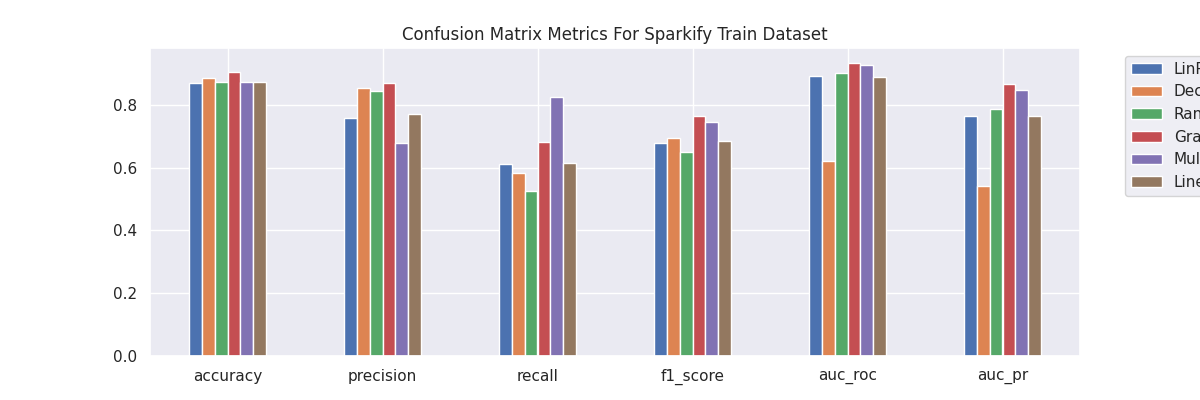

In [27]:
# to avoid stacking the plots, uncomment for AWS
plt.clf()

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,4)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["LinReg", "DecTrees", 
                         "RandForest", "GradBoost", 
                         "MultiLPerceptron", "LinearSVM"], rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# create title and labels
plt.title("Confusion Matrix Metrics For Sparkify Train Dataset")
ax.set_xlabel("");
ax.set_ylabel("");

# display the plot, uncomment for AWS
%matplot plt

## <font color='blue'>Tune Hyperparameters for the Best Classifiers</font>

### <font color='blue'>Multilayer Perceptron Classifier Tuning</font>

In [28]:
# this is the best classifier for the full dataset
print("")
print(f"Training MULTILAYER PERCEPTRON CLASSIFIER")
print("")

# specify layers: 18 (features), two hidden (8, 4), output 2 (classes)
layers=[18, 8, 4, 2]
# create the trainer and set its parameters
classifier_mlpc = MultilayerPerceptronClassifier(labelCol = labelCol,
                                                featuresCol = featuresCol,
                                                layers=layers,
                                                seed=1234)
# build specific pipeline
pipeline_mlpc = build_full_pipeline(classifier_mlpc)

# create a list of parameters for Multilayer Perceptron
param_mlpc = ParamGridBuilder() \
        .addGrid(classifier_mlpc.maxIter, [100, 200]) \
        .addGrid(classifier_mlpc.blockSize, [16, 64, 128]) \
        .addGrid(classifier_mlpc.stepSize, [0.01, 0.03, 0.1]) \
        .build()

print(f"Models trained: {len(param_mlpc)}")

# build the grid search pipeline
mlpc = grid_search_model(pipeline_mlpc, param_mlpc)

# start timer
start_time = time.time()

# train the model
model_mlpc = mlpc.fit(train_cached)

# drop the train set from memory at this point, uncomment on AWS
#train_cached.unpersist()

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_mlpc = model_mlpc.transform(test_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderROC"})
pr_mlpc = evaluator.evaluate(predictions_mlpc, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc = conf_metrics(predictions_mlpc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-27:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'




Training MULTILAYER PERCEPTRON CLASSIFIER

Models trained: 18

Training time.........67.984 min

In [29]:
# print all evaluation metrics
print("")
display_metrics(predictions_mlpc, roc_mlpc, pr_mlpc)
print("")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-28:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'





Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 1224|
|  0.0|       1.0|  598|
|  1.0|       0.0|  249|
|  0.0|       0.0| 4485|
+-----+----------+-----+


accuracy............... 0.871
precision.............. 0.672
recall................. 0.831
F1..................... 0.743
auc_roc................ 0.930
auc_pr................. 0.841

In [30]:
# print the best parameters from the grid
best_param_mlpc = list(model_mlpc.getEstimatorParamMaps()[np.argmax(model_mlpc.avgMetrics)].values())
param_mlpc1 = best_param_mlpc[0]
param_mlpc2 = best_param_mlpc[1]
param_mlpc3 = best_param_mlpc[2]
print("The best hyperparameter values from the grid:")
print("maxIter:..........", param_mlpc1)
print("blockSize:...........", param_mlpc2)
print("stepSize:.........", param_mlpc3)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The best hyperparameter values from the grid:
maxIter:.......... 100
blockSize:........... 128
stepSize:......... 0.01

Exception in thread cell_monitor-29:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-30:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



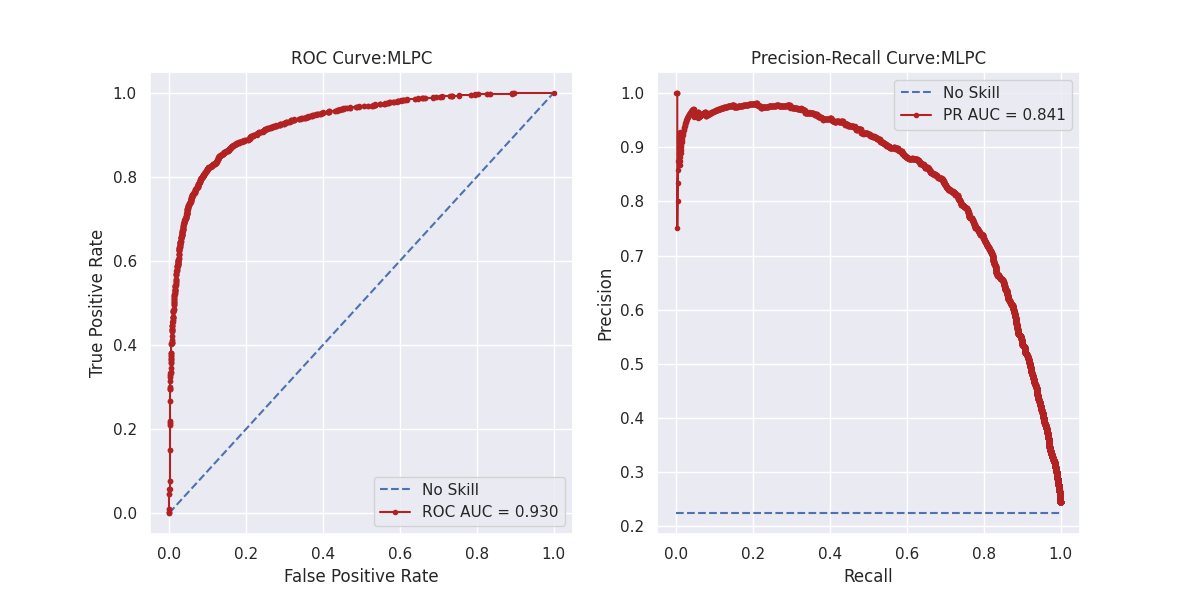

In [31]:
plt.clf()

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_mlpc, "MLPC")

%matplot plt

### <font color='blue'>Gradient Boosted Trees Classifier Tuning</font>

In [32]:
print("")
print(f"Training GRADIENT BOOSTED TREES")
print("")

# instantiate the classifier
classifier_gbt = GBTClassifier(labelCol = labelCol,
                               featuresCol = featuresCol,
                               seed=1234)
# build specific pipeline
pipeline_gbt = build_full_pipeline(classifier_gbt)

# create the parmeters list
param_gbt = ParamGridBuilder() \
        .addGrid(classifier_gbt.maxDepth, [15]) \
        .addGrid(classifier_gbt.maxBins, [32]) \
        .addGrid(classifier_gbt.maxIter, [10, 20]) \
        .addGrid(classifier_gbt.stepSize, [0.05, 0.1]) \
        .build()

print(f"Models trained: {len(param_gbt)}")

# build the grid search model
gbt = grid_search_model(pipeline_gbt, param_gbt)

# start timer
start_time = time.time()

# train the model
model_gbt = gbt.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)

# create the predictions dataset
predictions_gbt = model_gbt.transform(test_cached)

# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(labelCol)

# calculate roc and pr scores
roc_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
pr_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics
acc_gbt, prec_gbt, rec_gbt, f1_gbt = conf_metrics(predictions_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-31:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'




Training GRADIENT BOOSTED TREES

Models trained: 4

Training time.........193.554 min

In [33]:
# print all evaluation metrics
print("")
print("GBT: Evaluation metrics on the test set")
display_metrics(predictions_gbt, roc_gbt, pr_gbt)
print("")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-32:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 68285




GBT: Evaluation metrics on the test set

Confusion Matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  989|
|  0.0|       1.0|  422|
|  1.0|       0.0|  484|
|  0.0|       0.0| 4661|
+-----+----------+-----+


accuracy............... 0.862
precision.............. 0.701
recall................. 0.671
F1..................... 0.686
auc_roc................ 0.892
auc_pr................. 0.780

In [35]:
# print the best parameters from the grid
best_param_gbt = list(model_gbt.getEstimatorParamMaps()[np.argmax(model_gbt.avgMetrics)].values())
param_gbt1 = best_param_gbt[0]
param_gbt2 = best_param_gbt[1]
param_gbt3 = best_param_gbt[2]
param_gbt4 = best_param_gbt[3]
print("The best hyperparameter values from the grid:")
print("maxDepth:.........", param_gbt1)
print("maxBins:..........", param_gbt2)
print("maxIter:...........", param_gbt3)
print("stepSize:.........", param_gbt4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The best hyperparameter values from the grid:
maxDepth:......... 15
maxBins:.......... 32
maxIter:........... 20
stepSize:......... 0.1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

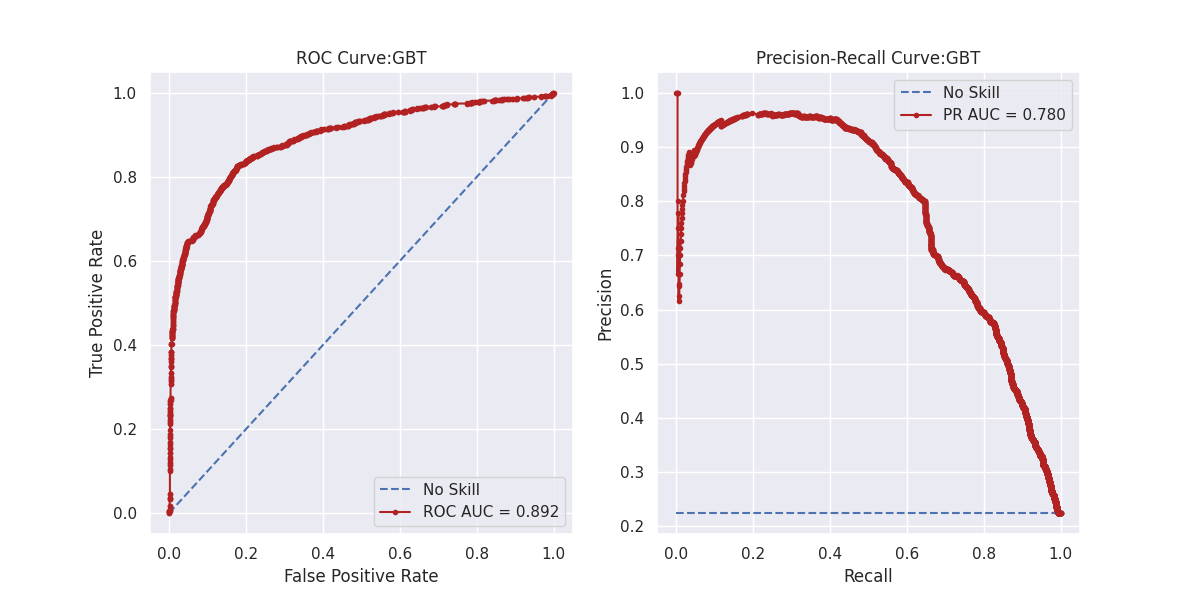

In [36]:
plt.clf()

# plot the ROC and PR curves
plot_roc_pr_curves(predictions_gbt, "GBT")

%matplot plt

### <font color='blue'>Compare Tuned Classifiers</font>

In [37]:
# function to plot the ROC and PR curves of the two best models
def plot_roc_pr_best_curves(predictions_model1, predictions_model2, model1, model2):
    
    """
    Plots the ROC and PR curves for two models on the same graphs.
    
    INPUT:
        predictions_model1 (PySpark dataframe) - contains probability predictions for the first model
        predictions_model2 (PySpark dataframe) - contains probability predictions for the second model
        model1, model2 (str) - abreviated model names
        
    OUTPUT:
        none - two plots are displayed
        
    """
    
    # transform predictions PySpark dataframe into Pandas dataframe
    pred1_pandas = predictions_model1.select(predictions_model1.label, 
                                             predictions_model1.probability).toPandas()
    pred2_pandas = predictions_model2.select(predictions_model2.label, 
                                             predictions_model2.probability).toPandas()
    
    # calculate roc_auc scores
    roc_auc1 = roc_auc_score(pred1_pandas.label, pred1_pandas.probability.str[1])
    # calculate roc_auc scores
    roc_auc2 = roc_auc_score(pred2_pandas.label, pred2_pandas.probability.str[1])
    
    # calculate roc curves for model 1
    fpr1, tpr1, _ = roc_curve(pred1_pandas.label, pred1_pandas.probability.str[1])
    # calculate roc curves for model 2
    fpr2, tpr2, _ = roc_curve(pred2_pandas.label, pred2_pandas.probability.str[1])
   
    # calculate precision, recall for each threshold for the first model
    precision1, recall1, _ = precision_recall_curve(pred1_pandas.label, 
                                                    pred1_pandas.probability.str[1])
    # calculate pr auc score for the first model
    pr_auc1 = auc(recall1, precision1)
    
    # calculate precision, recall for each threshold for the second model
    precision2, recall2, _ = precision_recall_curve(pred2_pandas.label, 
                                                    pred2_pandas.probability.str[1])
    # calculate pr auc score for the second model
    pr_auc2 = auc(recall2, precision2)
    
    # create figure which contains two subplots
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    
    # plot the roc curves
    plt.plot(fpr1, tpr1, marker='.', color='firebrick', label=model1 + ': ROC AUC = %.3f' % (roc_auc1))
    plt.plot(fpr2, tpr2, marker='.', color='green', label=model2 + ': ROC AUC = %.3f' % (roc_auc2))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # figure title
    plt.title("ROC Curves")
    
    plt.subplot(122)
    
    # plot the precision-recall curves
    plt.plot(recall1, precision1, marker='.', color="firebrick", label=model1 + ': PR AUC = %.3f' % (pr_auc1))
    plt.plot(recall2, precision2, marker='.', color="green", label=model2 +': PR AUC = %.3f' % (pr_auc2))
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # figure title
    plt.title("Precision-Recall Curves")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

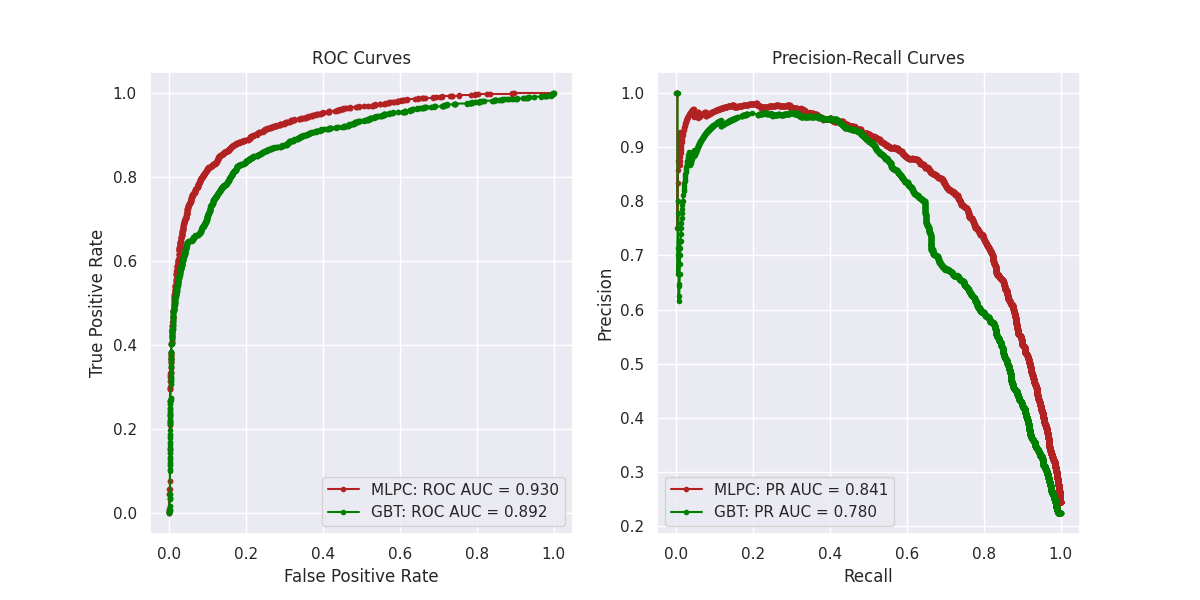

In [38]:
plt.clf()

# plot the two pairs of curves for comparison
plot_roc_pr_best_curves(predictions_mlpc, predictions_gbt, "MLPC", "GBT")

%matplot plt

In [39]:
# create Pandas dataframe with evaluation metrics for the best hyperparameters selection
dict_metrics = {"GradBoost": [acc_gbt, prec_gbt, rec_gbt, f1_gbt, roc_gbt, pr_gbt],
                "MultiLPerceptron": [acc_mlpc, prec_mlpc, rec_mlpc, f1_mlpc, roc_mlpc, pr_mlpc],
                "list_metrics" : ["accuracy", "precision", "recall", "f1_score", "auc_roc", "auc_pr"]
               }
df_mets = pd.DataFrame.from_dict(dict_metrics).set_index("list_metrics")
df_mets.round(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              GradBoost  MultiLPerceptron
list_metrics                             
accuracy          0.862             0.871
precision         0.701             0.672
recall            0.671             0.831
f1_score          0.686             0.743
auc_roc           0.892             0.930
auc_pr            0.780             0.841

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

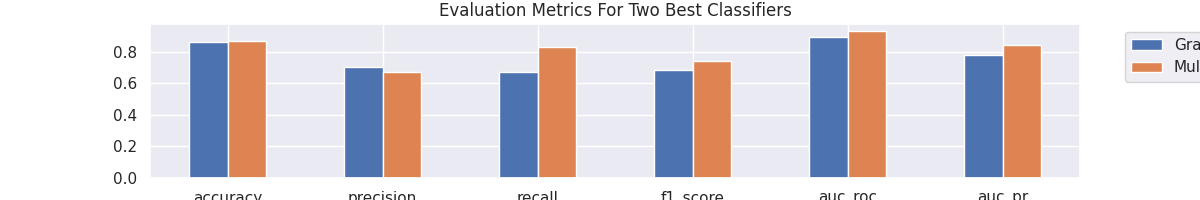

In [40]:
# barplot of the evaluation metrics for the two models, for comparison

plt.clf()

# adjust figure size and font size
sns.set(rc = {"figure.figsize":(12,2)})

sns.set(font_scale=1)
ax = df_mets.plot.bar(y=["GradBoost", "MultiLPerceptron"], rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# create title and labels
plt.title("Evaluation Metrics For Two Best Classifiers")
ax.set_xlabel("");
ax.set_ylabel("");

%matplot plt